In [1]:

import numpy as np
from numpy.polynomial import Polynomial
import scipy.stats
import scipy.interpolate
import scipy.integrate
import pandas as pd
import os

from astropy.coordinates import sky_coordinate as SkyCoord, ICRS,Galactic
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table

import time
from functools import partial
from multiprocessing import pool
import argparse

from configparser import RawConfigParser  # python 3

import matplotlib.pyplot as plt

In [2]:

def read_ini(filename):
    ini = RawConfigParser()
    ini.optionxform=str  # do not convert key to lowercase
    ini.read(filename)
    return ini

In [3]:

def getAlamAV_WC19(lam): 
    """
    Given the effective wavelenght of a photometric filter, returns the expected absoprtion in that band divided by the absorption in V.
    Calculate Eqs.(9)-(10) of Wang & Chen (2019), ApJ, 877, 116

    - lam: wavelenght in nm
    """
    if (lam < 1000): # in nm
        Y1 = 1000/lam - 1.82; # 1/um - 1.82
        as_ = np.array([0.7499, -0.1086, -0.08909, 0.02905, 0.01069, 0.001707, -0.001002])
        AlamAV = 1+np.sum(as_*np.array([Y1**(i+1) for i in range(7)]))
        return AlamAV
    else:
        return 0.3722*pow(1000/lam, 2.07)

def getHscale(b):
    """
    Nataf+13
    b in degrees
    """
    return 164/(np.abs(np.sin(np.deg2rad(b)))+1e-4) 

def getDmean(l,b):
    """
    Eqs(2)-(3) of Nataf+16
    l,b in degrees
    """
    DMrc = 14.3955 - 0.0239 * l + 0.0122*abs(b)+0.128;
    return 10**(0.2*DMrc) * 10



    
def get_pos(D,l,b,Dsun=8160,zsun=25,xyzSgrA = [-0.01362815601805778, -7.941887440118567, -6.574101760251946],_cyl=True):
    """
    Given a line of sight (l,b in degrees) and a distance, compute the Galactocentric distance in either cartessian or cylindrical coordinates

    - D: distance (any units)
    - lD: Galactic longitude (degrees)
    - bD: Galactic latitude (degrees)
    - Dsun: Galactocentric distance to the Sun (in pc)
    - zsun: height of the Sun (pc)
    - xyzSgrA (iterable): location in XYZ Galactocentric cartesian coordinates of SgrA*.

    CAREFUL! Left-handed system.
    """
    x,y,z = Dlb2xyz(D,l,b,Dsun,zsun,xyzSgrA)
    
    if _cyl:
        return np.sqrt(x**2 + y**2),z
    else:
        return x,y,z
    

In [4]:
def Dlb2xyz(D,lD,bD,Dsun = 8160,zsun=25,xyzSgrA = [-0.01362815601805778, -7.941887440118567, -6.574101760251946]):
    """
    Transform from distance and Galactic coordinates to XYZ Galactocentric cartesian coordinates.(LEFT HANDED!)

    - D: distance (any units)
    - lD: Galactic longitude (degrees)
    - bD: Galactic latitude (degrees)
    - Dsun: Galactocentric distance to the Sun (in pc)
    - zsun: height of the Sun (pc)
    - xyzSgrA (iterable): location in XYZ Galactocentric cartesian coordinates of SgrA*.
    """
    sinbsun = zsun/Dsun
    bsun = np.arcsin(sinbsun)
    cosbsun = np.cos(bsun)
    cosb = np.cos(np.deg2rad(bD))
    sinb = np.sin(np.deg2rad(bD))
    cosl = np.cos(np.deg2rad(lD))
    sinl = np.sin(np.deg2rad(lD))
    
    x = D*cosb*cosl
    y = D*cosb*sinl
    z = D*sinb
    
    x = x*cosbsun-z*sinbsun
    z = z*cosbsun + x*sinbsun
    return [Dsun*cosbsun - x - xyzSgrA[0],y - xyzSgrA[1],z - zsun - xyzSgrA[2]]

In [5]:
def IMF_prob(mass,Mu = 120,M1 = 0.859770466578045,M2 = 0.08,Ml = 0.001,
             alpha1 = 2.32279457078378,alpha2 = 1.13449983242887,alpha3 = 0.175862190587576):
    
    C1_ = M1**(1-alpha1)*(alpha2-alpha1)/((1-alpha1)*(1-alpha2)) + M1**(alpha2-alpha1)*M2**(1-alpha2)*(alpha3-alpha2)/((1-alpha2)*(1-alpha3))-\
            (Mu**(1-alpha1)/(1-alpha1) + Ml**(1-alpha3)*M2**(alpha3-alpha2)*M1**(alpha2-alpha1)/(1-alpha3))
    C1 = 1/C1_
    C2 = C1*M1**(alpha2-alpha1)
    C3 = C2*M2**(alpha3-alpha2)

    PlogM = np.zeros_like(mass)

    mask1 = (mass>M1) & (mass<=Mu)
    mask2 = (mass>M2) & (mass<=M1)
    mask3 = (mass>Ml) & (mass<=M2)

    PlogM[mask1] = C1*(mass[mask1])**(1-alpha1)
    PlogM[mask2] = C2*(mass[mask2])**(1-alpha2)
    PlogM[mask3] = C3*(mass[mask3])**(1-alpha3)

    return PlogM

In [6]:
#load constants
cts = read_ini("../Koshimoto21_E_EX_constants.ini")

bandnames = ["J","H","Ks"]

    #dump constants into variables
components_names = cts["Basic"]["components"].split(cts["Basic"]["separator"])
print(components_names)
def_mag_err = cts["data"]["default_photerror"]
if def_mag_err == "none":
    def_mag_err = None
else:
    def_mag_err = float(def_mag_err)
min_mag_error = cts["Basic"].getfloat("mag_error_threshold",fallback=0.05)
    
photsys = cts["Basic"]["photsys"]
lamJ = cts[photsys].getfloat("J",fallback="This band does not exist")
lamH = cts[photsys].getfloat("H",fallback="This band does not exist")
lamKs = cts[photsys].getfloat("Ks",fallback="This band does not exist")

Mu = cts["IMF"].getfloat("Mass_max") #max mass
Ml = cts["IMF"].getfloat("Mass_min") #min mass
nM = cts["IMF"].getint("num_bins_M")
IMF_params = {"Mu":Mu,"Ml":Ml,"M1":cts["IMF"].getfloat("M1"),"M2":cts["IMF"].getfloat("M2"),
                 "alpha1":cts["IMF"].getfloat("alpha1"),"alpha2":cts["IMF"].getfloat("alpha2"),"alpha3":cts["IMF"].getfloat("alpha3")} #,"norm":cts["IMF"].getfloat("norm")

Dmax = cts["Basic"].getfloat("Dmax") #max distance in pc
Dmin = cts["Basic"].getfloat("Dmin") #min distance in pc
nD = cts["Basic"].getint("num_bins_D")
icomps = len(components_names)

sig_lim = cts["Basic"].getfloat("sigma_threshold")
sig_cut = cts["Basic"].getint("counts_lim")

n0MS = [cts[name].getfloat("n0MS",fallback=0.0) for name in components_names]

if "bar" in components_names:
    bar_angle = cts["bar"].getfloat("bar_angle")
else:
    bar_angle = None

costheta = np.cos(np.deg2rad(bar_angle))
sintheta = np.sin(np.deg2rad(bar_angle))


    #prepare other constants
EJKAV = getAlamAV_WC19(1254.0) - getAlamAV_WC19(2149.0); # 1254.0 = lamJ,VVV, 2149.0 = lamK,VVV 
EJK2AJ = getAlamAV_WC19(lamJ)/EJKAV
EJK2AH = getAlamAV_WC19(lamH)/EJKAV
EJK2AKs = getAlamAV_WC19(lamKs)/EJKAV

['thin1', 'thin2', 'thin3', 'thin4', 'thin5', 'thin6', 'thin7', 'thick', 'bar', 'nsd', 'nsc']


In [8]:
MLdirectory = "../input_files/"

#Load files and create interpolators
EXTMAPfile = cts["Basic"]["EXTMAPfile"]
rot_curve_file = cts["Basic"]["ROTCURVEfile"]
    #load rotation curve and create interpolator
rot_curve_data = np.loadtxt(MLdirectory+rot_curve_file,delimiter=",",comments="#")
#rot_curve_data[:,0] in kiloparsecs! NEED TO CONVERT TO PARSECS 
rotation_curve_intp = scipy.interpolate.interp1d(rot_curve_data[:,0]*1000,rot_curve_data[:,1],kind="linear",bounds_error=False,)
    #load ML and create interpolators


mass_index = cts[photsys].getint("ML_mass_offset")
ML_mag_offset = cts[photsys].getint("ML_mag_offset")
ML_mag_sig_offset = cts[photsys].getint("ML_mag_sigma_offset")
ML_mag_max_offset = cts[photsys].getint("ML_mag_max_offset")
ML_mag_min_offset = cts[photsys].getint("ML_mag_min_offset")

ML_colour_offset = cts[photsys].getint("ML_colour_offset")
ML_colour_sig_offset = cts[photsys].getint("ML_colour_sigma_offset")
ML_colour_max_offset = cts[photsys].getint("ML_colour_max_offset")
ML_colour_min_offset = cts[photsys].getint("ML_colour_min_offset")

ML = [np.loadtxt(MLdirectory+file) for component,file in dict(cts[cts["Basic"]["photsys"]]).items() if component.endswith("file")]
mag_interpolators = []
col_interpolators = []
for icomp,ML_i in enumerate(ML):
    log10mass = np.log10(ML_i[:,mass_index])
        #absolute magnitudes corresponding to each mass: Mass-Luminosity relation
    mag_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_mag_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #dispersion in magnitudes at each mass bin resulting from age and metallicity dispersion
    mag_sigma_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_mag_sig_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #faintest magnitude attainable at each mass bin
    mag_max_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_mag_max_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #brightest magnitude attainable at each mass bin
    mag_min_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_mag_min_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
    mag_interpolators.append(mag_interpol+mag_sigma_interpol+mag_max_interpol+mag_min_interpol)

        #colour corresponding to each mass: Mass-Luminosity relation
    col_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_colour_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #dispersion in colour at each mass bin resulting from age and metallicity dispersion
    col_sigma_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_colour_sig_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #reddest colour attainable at each mass bin
    col_max_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_colour_max_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #bluest colour attainable at each mass bin
    col_min_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_colour_min_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
    col_interpolators.append(col_interpol+col_sigma_interpol+col_max_interpol+col_min_interpol)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_4676/2748850108.py:28: RuntimeWarning: divide by zero encountered in log10
  log10mass = np.log10(ML_i[:,mass_index])


In [9]:
#load EXTMAP
extmap = np.loadtxt(MLdirectory+EXTMAPfile,delimiter=cts["Basic"]["EXTMAPdelimiter"])

# Plot interpolators and compare to their HR diagrams

In [10]:
logmass_bins = np.linspace(0,1,20000)

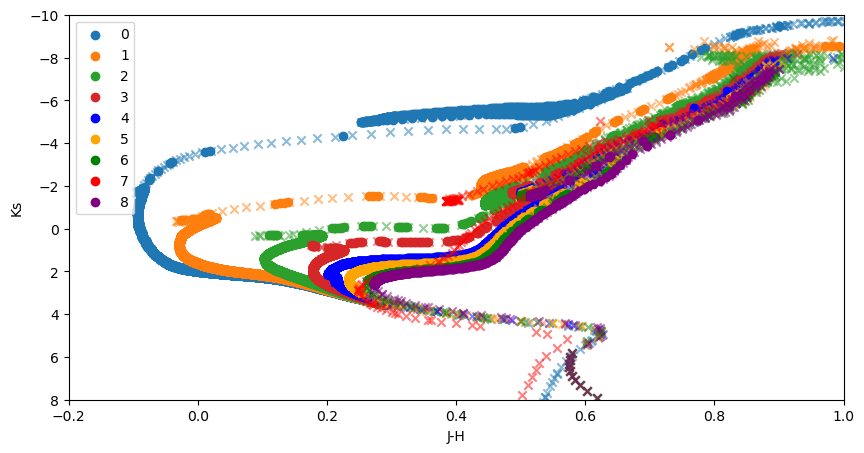

In [11]:
fig,axes = plt.subplots(figsize=(10,5))

colors = ["tab:blue","tab:orange","tab:green","tab:red","blue","orange","green","red","purple"]

for i in range(9):
    Jmag = mag_interpolators[i][0](logmass_bins)
    Hmag = mag_interpolators[i][1](logmass_bins)
    Ksmag = mag_interpolators[i][2](logmass_bins)
    
    cc = axes.scatter(Jmag-Hmag,Ksmag,label="{}".format(i),c=colors[i],marker="o",rasterized=True)
    axes.scatter(ML[i][:,0+ML_mag_offset]-ML[i][:,1+ML_mag_offset],ML[i][:,2+ML_mag_offset],c=colors[i],marker="x",alpha=0.5)

axes.set_xlabel("J-H")
axes.set_ylabel("Ks")
axes.set_ylim(8,-10)
axes.set_xlim(-0.2,1)
axes.legend();

In [12]:
ML[0].shape

(468, 37)

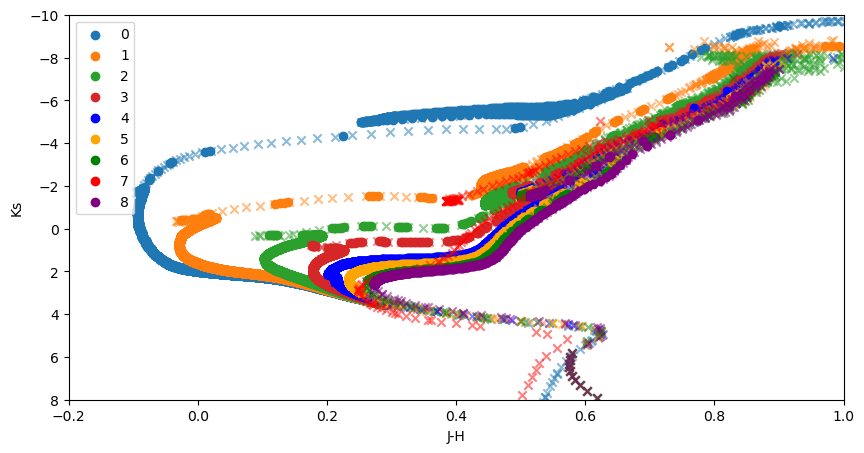

In [13]:
fig,axes = plt.subplots(figsize=(10,5))

colors = ["tab:blue","tab:orange","tab:green","tab:red","blue","orange","green","red","purple"]

for i in range(9):
    JHcol = col_interpolators[i][0](logmass_bins)
    Ksmag = mag_interpolators[i][2](logmass_bins)
    
    cc = axes.scatter(JHcol,Ksmag,label="{}".format(i),c=colors[i],marker="o",rasterized=True)
    axes.scatter(ML[i][:,0+ML_colour_offset],ML[i][:,2+ML_mag_offset],c=colors[i],marker="x",alpha=0.5)

axes.set_xlabel("J-H")
axes.set_ylabel("Ks")
axes.set_ylim(8,-10)
axes.set_xlim(-0.2,1)
axes.legend();

# Measure distance from observation to each of the HR diagrams

In [14]:
def get_gaussian_distance(mags_notnan,mag_errors_notnan,dist_bins,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan):
    return np.stack([get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan) for D in dist_bins])

def get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan):
    """
    If the magnitude of a band is fainter than the max magnitude, it is heavily penalised (+99 sigmas)
    """
    prob = np.sum([(mag_ - (MLi[:,ML_indices[i]] + A0s_notnan[i]*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))))**2/\
                   (mag_errors_notnan[i]**2 + MLi[:,sigma_indices[i]]**2) + \
        99*np.heaviside(mag_ - (MLi[:,max_indices[i]] + A0s_notnan[i]*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))),1) \
                   for i,mag_ in enumerate(mags_notnan)],axis=0)
    return prob
    
def gaussian_cdf(x,mu,sigma):
    return 0.5*(1+scipy.special.erf((x-mu)/sigma/np.sqrt(2)))

def gaussian_truncated_pdf(x,mu,sigma,x_max):
    return 1/gaussian_cdf(x_max,mu,sigma)*np.heaviside(x_max - x,1)/np.sqrt(2*np.pi)/sigma*np.exp(-1/2*((x - mu)/sigma)**2)

def get_likelihood(mags_notnan,mag_errors_notnan,mass,D,interpolator,interpol_indices,hscale,EJKs,A0s_notnan):
    """
    Product of N truncated gaussian distributions, each one normalised to area 1.

    Interpolator is a list object with 9 interpolators inside, all function of log10(mass):
    - three (0-2) for photometry: J, H and Ks
    - three (3-5) for the dispersion in these three bands (result of age and metallicity dispersions)
    - three (6-8) for the faintest magnitude achivable with that mass. 

    The faintest magnitude truncates the gaussian.
    """
        #escale absorption by the distance
    DM = 5 * np.log10(0.1*(D + 0.1))
    Dist_scale = (1 - np.exp(-D/hscale))
    log10mass = np.log10(mass)
    return np.nan_to_num(np.prod([gaussian_truncated_pdf(mag_,interpolator[interpol_indices[i]](log10mass) + A0s_notnan[i]*EJKs*Dist_scale + DM,np.sqrt((mag_errors_notnan[i]**2 + (interpolator[interpol_indices[i]+len(bandnames)](log10mass))**2)),interpolator[interpol_indices[i]+2*len(bandnames)](log10mass) + A0s_notnan[i]*EJKs*Dist_scale + DM) for i,mag_ in enumerate(mags_notnan)],axis=0))

In [15]:
def get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan):
    return np.stack([get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan) for D in dist_bins])


In [17]:
def get_gaussian_prob2D_atD(observed_mag,mag_error,observed_colour,colour_error,mag_index,colour_index,absorption_ratio,extinction_ratio,
                                D,EJKs,hscale,MLi,ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,ML_colour_offset,
                                ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset):
    """
    For a given mass-luminosity relation (one component, one isochrone) at a given distance, 
    compute the separation in the CMD space between all the masses and the observed star
    """
    DM = absorption_ratio*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))
    extinction = extinction_ratio*EJKs*(1 - np.exp(-D/hscale))

    sig2_mag = mag_error**2 + MLi[:,mag_index+ML_mag_sig_offset]**2
    sig2_col = colour_error**2 + MLi[:,colour_index+ML_colour_sig_offset]**2

    distance = (observed_mag-(MLi[:,mag_index+ML_mag_offset] + DM))**2/sig2_mag + (observed_colour-(MLi[:,colour_index+ML_colour_offset] + extinction))**2/sig2_col
    prob = scipy.stats.norm.pdf(distance)

    return prob


In [76]:
def get_gaussian_distance2D_atD(observed_mag,mag_error,observed_colour,colour_error,mag_index,colour_index,absorption_ratio,extinction_ratio,
                                D,EJKs,hscale,MLi,ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,ML_colour_offset,
                                ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset):
    """
    For a given mass-luminosity relation (one component, one isochrone) at a given distance, 
    compute the separation in the CMD space between all the masses and the observed star
    """
    DM = absorption_ratio*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))
    extinction = extinction_ratio*EJKs*(1 - np.exp(-D/hscale))

    sig2_mag = mag_error**2 #+ MLi[:,mag_index+ML_mag_sig_offset]**2
    sig2_col = colour_error**2 #+ MLi[:,colour_index+ML_colour_sig_offset]**2

    distance = (observed_mag-(MLi[:,mag_index+ML_mag_offset] + DM))**2/sig2_mag + (observed_colour-(MLi[:,colour_index+ML_colour_offset] + extinction))**2/sig2_col
    #heavily penalise whenever we are out of bounds
    mask1 = observed_mag>(MLi[:,mag_index+ML_mag_max_offset] + DM)
    mask2 = observed_mag<(MLi[:,mag_index+ML_mag_min_offset] + DM)
    mask3 = observed_colour>(MLi[:,colour_index+ML_colour_max_offset] + extinction)
    mask4 = observed_colour<(MLi[:,colour_index+ML_colour_min_offset] + extinction)

    distance[mask1] = 999
    distance[mask2] = 999
    distance[mask3] = 999
    distance[mask4] = 999

    return distance


In [59]:
def get_gaussian_prob2D_atD(distance):
    prob = scipy.stats.norm.pdf(distance)

    return prob


In [81]:
l = 0
b = 0

mag = 15
mag_error = 0.1
col = 2.5
col_error = 0.1
D = 5500 #pc

interpol_indices = np.array([0,1,2])
mag_index = 2
col_index = 0

hscale = getHscale(b)
Dmean = getDmean(l,b)
EJKs =  extmap[np.argmin(np.sqrt((extmap[:,0]-l)**2+(extmap[:,1]-b)**2))][-1]
A0J = EJK2AJ/(1 - np.exp(-Dmean/hscale))
A0H = EJK2AH/(1 - np.exp(-Dmean/hscale))
A0Ks = EJK2AKs/(1 - np.exp(-Dmean/hscale))
A0s = [A0J,A0H,A0Ks]
E0s = [A0J-A0H,A0J-A0Ks,A0H-A0Ks]

absorption_ratio = A0s[mag_index]
extinction_ratio = E0s[col_index]

sig_lim = 10

In [ ]:
def IMF_dNdlogm(mass,Mu = 120,M1 = 0.859770466578045,M2 = 0.08,Ml = 0.001,
             alpha1 = 2.32279457078378,alpha2 = 1.13449983242887,alpha3 = 0.175862190587576):
    
    C1_ = M1**(1-alpha1)*(alpha2-alpha1)/((1-alpha1)*(1-alpha2)) + M1**(alpha2-alpha1)*M2**(1-alpha2)*(alpha3-alpha2)/((1-alpha2)*(1-alpha3))-\
            (Mu**(1-alpha1)/(1-alpha1) + Ml**(1-alpha3)*M2**(alpha3-alpha2)*M1**(alpha2-alpha1)/(1-alpha3))
    C1 = 1/C1_
    C2 = C1*M1**(alpha2-alpha1)
    C3 = C2*M2**(alpha3-alpha2)

    PlogM = np.zeros_like(mass)

    mask1 = (mass>M1) & (mass<=Mu)
    mask2 = (mass>M2) & (mass<=M1)
    mask3 = (mass>Ml) & (mass<=M2)

    PlogM[mask1] = C1*(mass[mask1])**(1-alpha1)
    PlogM[mask2] = C2*(mass[mask2])**(1-alpha2)
    PlogM[mask3] = C3*(mass[mask3])**(1-alpha3)

    return PlogM

In [20]:
mass_bins = ML[i][:,0]

In [43]:
mass_bins = np.logspace(np.log10(cts["IMF"].getfloat("Mass_min")*0.9),np.log10(cts["IMF"].getfloat("Mass_max")*1.1),10000)

In [44]:
prior_mass = IMF_dNdlogm(mass_bins,**IMF_params)

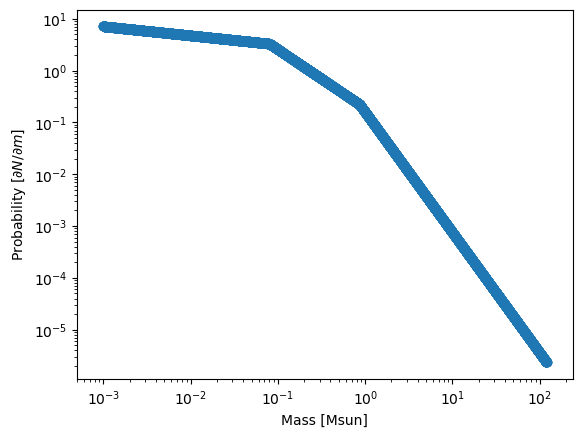

In [45]:
plt.scatter(mass_bins,1/mass_bins*prior_mass)
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.xlabel("Mass [Msun]")
plt.ylabel(r"Probability [$\partial N/\partial m$]");

In [46]:
scipy.integrate.simpson(1/mass_bins*prior_mass,x=mass_bins)

0.9995769885245812

In [ ]:
np.sum(1/mass_bins[:-1]*prior_mass[:-1]*(mass_bins[1:]-mass_bins[:-1]))

1.0001704965174802

In [49]:
np.sum(1/mass_bins[1:]*prior_mass[1:]*(mass_bins[1:]-mass_bins[:-1]))

0.9989812904790125

In [84]:
dist_bins = np.logspace(np.log10(Dmin),np.log10(12000),10000+1)

In [82]:
selected_particles = []
all_dists_std = []
likelihoods = []
priors = []
posteriors = []
for icomp_,MLi in enumerate(ML):
    #To-Do: check if it works with only one magnitude
    dist_std = get_gaussian_distance2D_atD(mag,mag_error,col,col_error,mag_index,col_index,absorption_ratio,extinction_ratio,D,EJKs,hscale,MLi,
                                          ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,
                                          ML_colour_offset,ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset,)
    all_dists_std.append(dist_std)
    L = scipy.stats.norm.pdf(dist_std)
    mass_bins = np.clip(MLi[:,0],a_min=IMF_params["Ml"],a_max=IMF_params["Mu"])
    prior = 1/mass_bins*IMF_dNdlogm(mass_bins)
    post = scipy.integrate.simpson(L*prior,mass_bins)
    likelihoods.append(L)
    priors.append(prior)
    posteriors.append(post)
    #B) Find points where distance is smaller than N-sigmas
    #close_HRd_mask = dist_std<sig_lim
    # close_HRd_mask_m = np.sum(close_HRd_mask,axis=1)
    # #C) Compute the likelihood
    # ## C.1) If there are NO points within N-sigma, simply ignore it
    # ## C.2) If there is only 1 point within N-sigma, then just integrate within 90% and 110% of the closest mass
    # ## C.3) Otherwise, numerically integrate within mass range (smallest and largest mass that are within 6sigma of observable)
    # mask = close_HRd_mask_m>sig_cut

    # selected_particles.append(MLi[mask])


In [83]:
posteriors

[1.2675673261127567e-174,
 1.500591888077152e-86,
 1.1077735557295437e-05,
 1.2633155885780444e-05,
 1.877407578620164e-05,
 6.889362070772893e-05,
 3.064198251273147e-05,
 4.235971218743421e-05,
 3.2621806822999956e-05,
 3.225935338077645e-05,
 3.225935338077645e-05]

In [84]:
for i,L in enumerate(likelihoods):
    print(i,np.sum(L),np.sum(priors[i]))

0 2.1213824444529693e-171 125.01352154792102
1 2.4180132555319007e-83 117.58064615354343
2 0.8204994081196707 133.44702681852658
3 0.7244465987280362 133.76909651006454
4 0.15222598253112343 135.92531445480566
5 0.539503879020537 138.8324016286815
6 0.5351935502000779 135.75878496373758
7 0.6956827911028846 147.20243379217928
8 0.42998041939884785 140.82758061353826
9 0.4697630992420174 138.05527366021818
10 0.4697630992420174 138.05527366021818


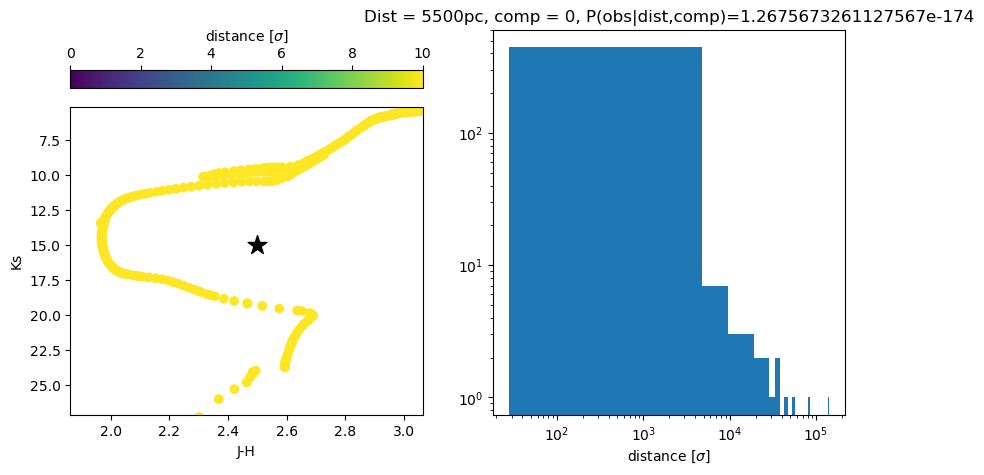

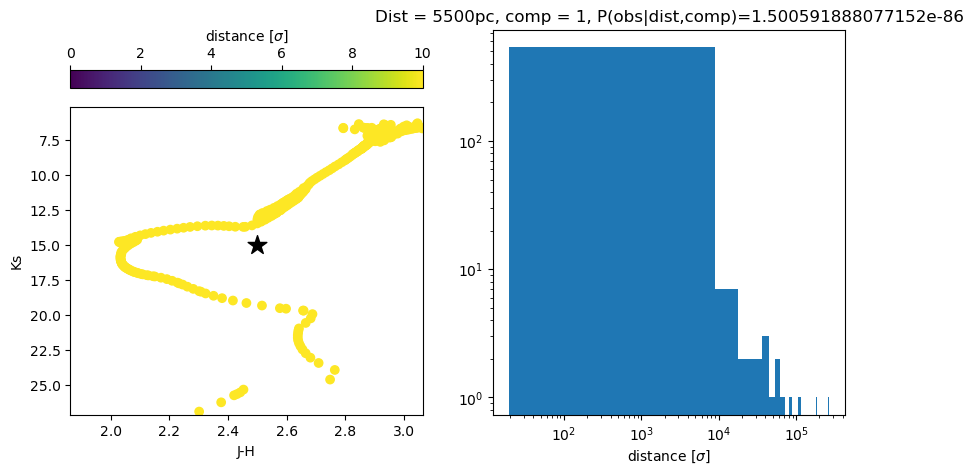

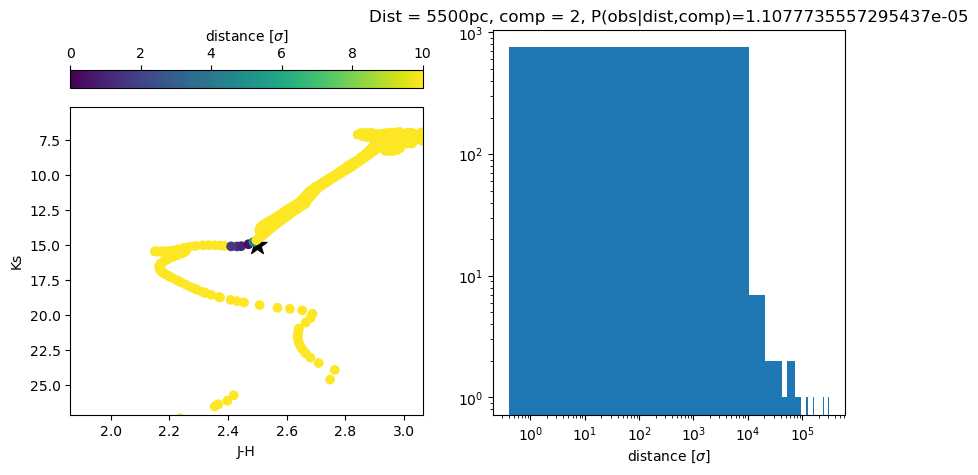

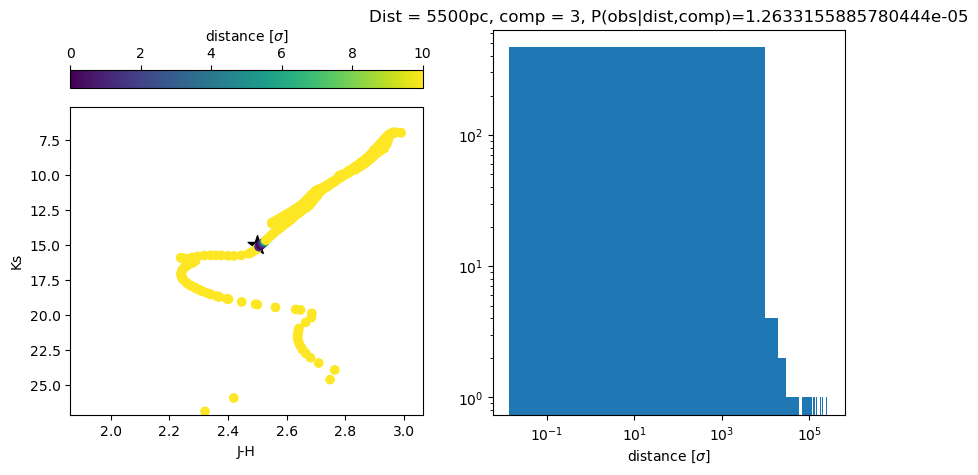

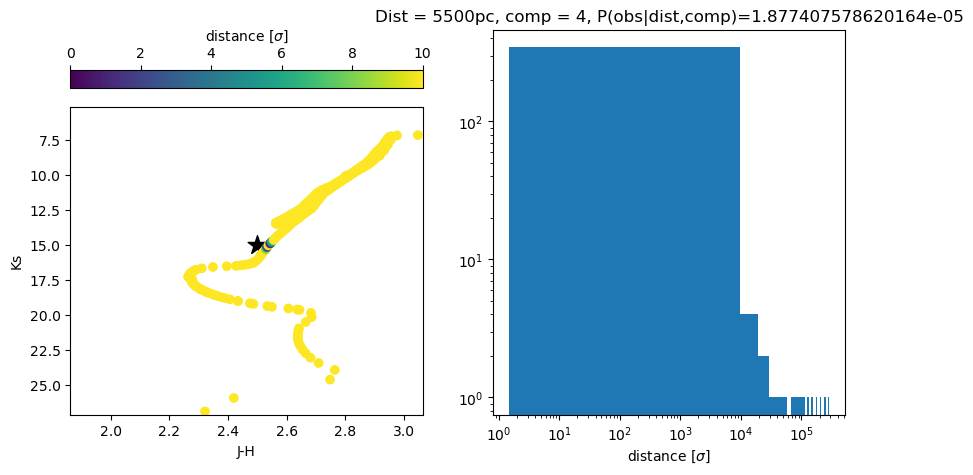

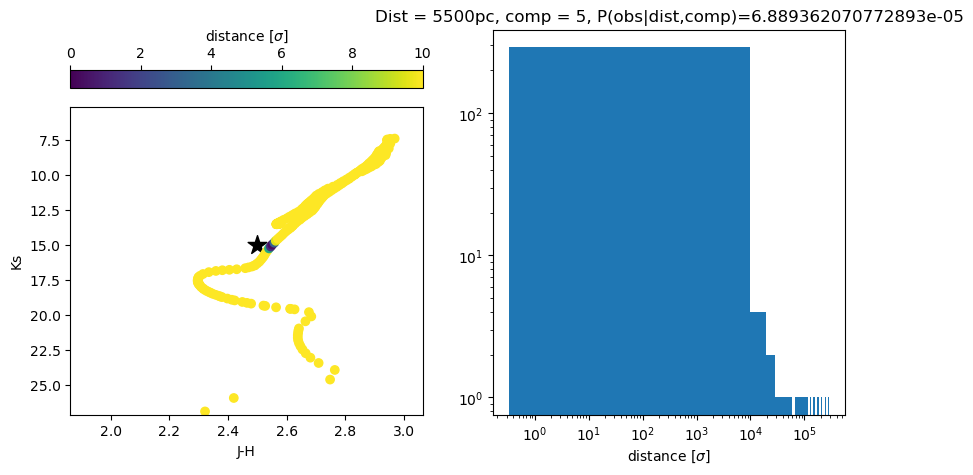

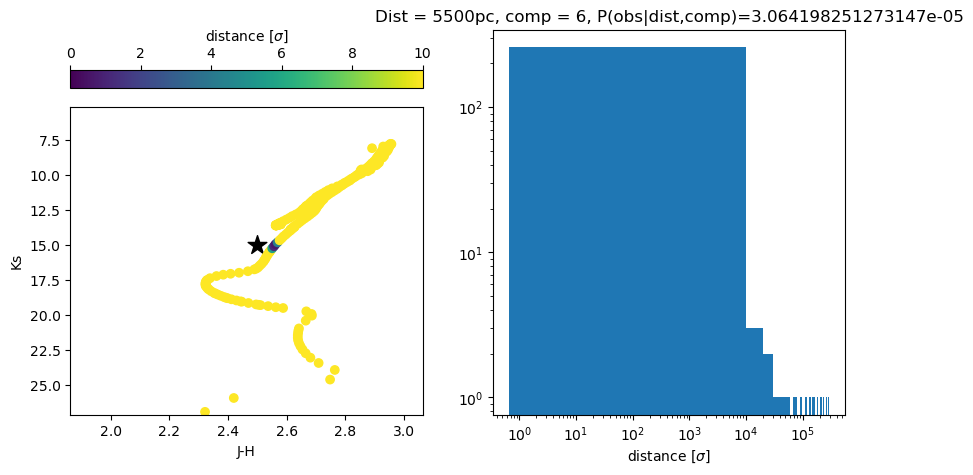

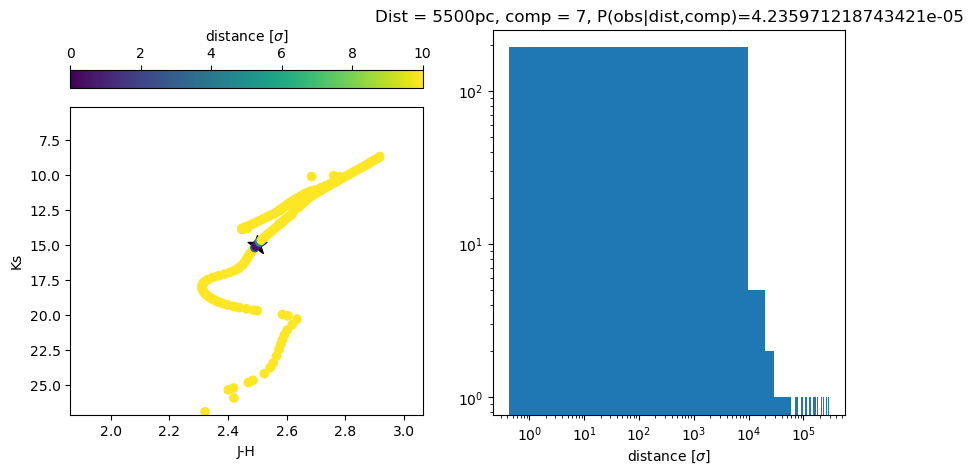

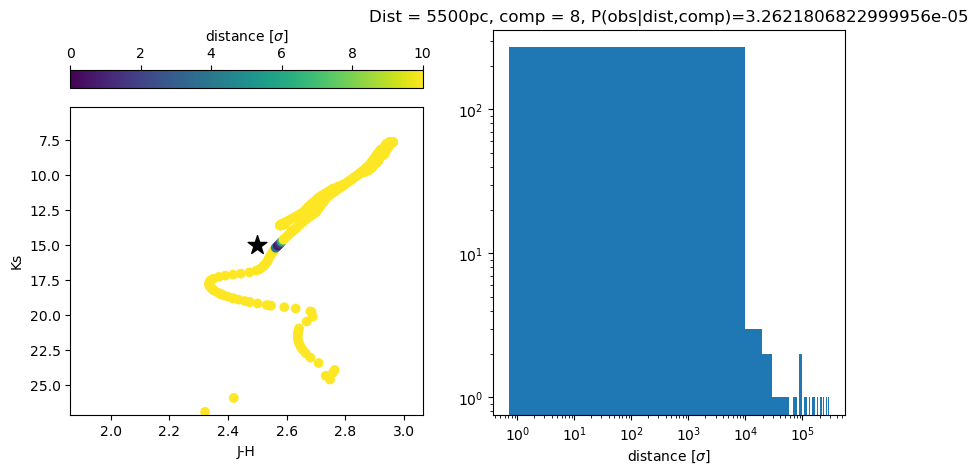

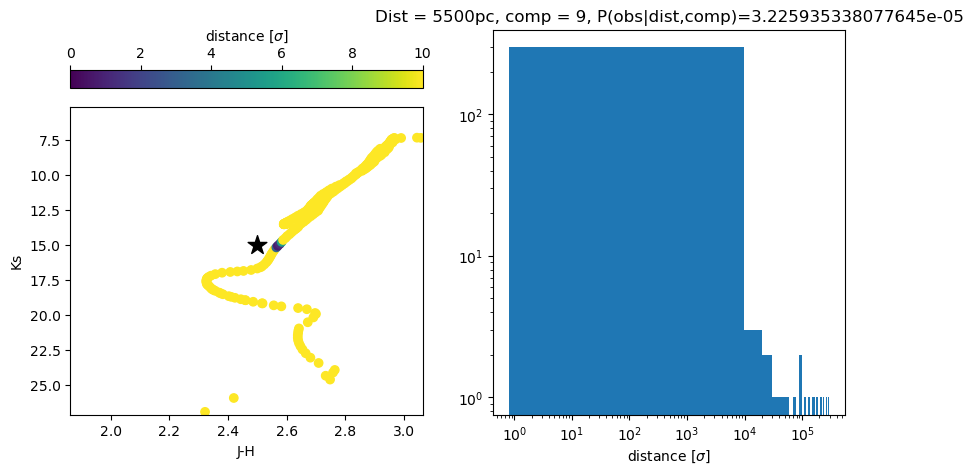

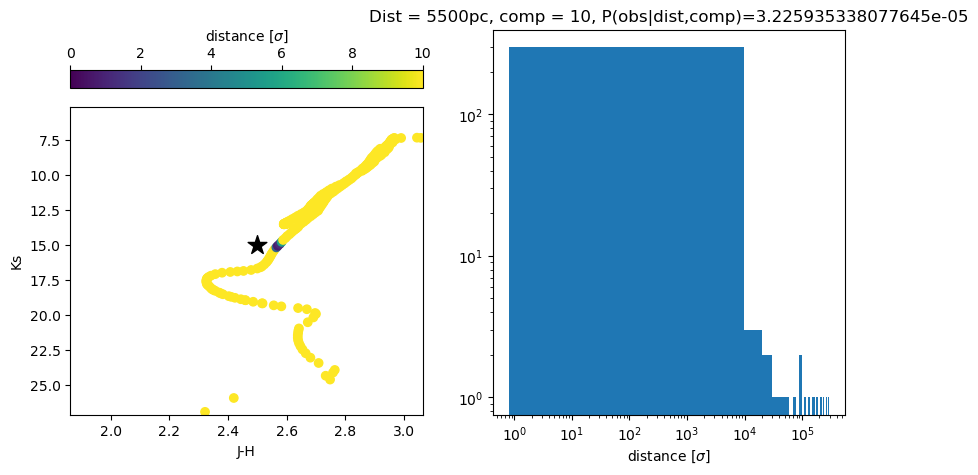

In [85]:
for i in range(len(ML)):

    fig,axes = plt.subplots(figsize=(10,5),ncols=2)

    DM = 5 * np.log10(0.1*(D + 0.1))
    Dist_scale = (1 - np.exp(-D/hscale))

    app_mag = ML[i][:,mag_index + ML_mag_offset] + absorption_ratio*EJKs*Dist_scale + DM
    app_col = ML[i][:,col_index + ML_colour_offset] + extinction_ratio*EJKs*Dist_scale

    axes[0].scatter(col,mag,marker="*",s=200,c="k")

    cc = axes[0].scatter(app_col,app_mag,c=all_dists_std[i],marker="o",alpha=1,vmin=0,vmax=10)
    plt.colorbar(cc,ax=axes[0],orientation="horizontal",location="top",label=r"distance [$\sigma$]")

    plt.title("Dist = {}pc, comp = {}, P(obs|dist,comp)={}".format(D,i,posteriors[i]))
    axes[0].set_xlabel("J-H")
    axes[0].set_ylabel("Ks")
    axes[0].set_ylim(12+ absorption_ratio*EJKs*Dist_scale + DM,-10+ absorption_ratio*EJKs*Dist_scale + DM)
    axes[0].set_xlim(-0.2+extinction_ratio*EJKs*Dist_scale,1+extinction_ratio*EJKs*Dist_scale);

    axes[1].hist(all_dists_std[i],bins=30,log=True)
    axes[1].set_xlabel(r"distance [$\sigma$]");
    axes[1].set_xscale("log");

In [108]:
dist_bins = np.arange(10,12000,50)

In [109]:
probabilities = []
for icomp_,MLi in enumerate(ML):
    probabilities_i = []
    mass_bins = np.clip(MLi[:,0],a_min=IMF_params["Ml"],a_max=IMF_params["Mu"])
    prior = 1/mass_bins*IMF_dNdlogm(mass_bins)
    for D in dist_bins:
        #To-Do: check if it works with only one magnitude
        dist_std = get_gaussian_distance2D_atD(mag,mag_error,col,col_error,mag_index,col_index,absorption_ratio,extinction_ratio,D,EJKs,hscale,MLi,
                                            ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,
                                            ML_colour_offset,ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset,)
        L = scipy.stats.norm.pdf(dist_std)
        post = scipy.integrate.simpson(L*prior,mass_bins)
        probabilities_i.append(post)
    probabilities.append(probabilities_i)
probabilities = np.array(probabilities)
norms = [scipy.integrate.simpson(p,x=dist_bins) for p in probabilities]

In [110]:
probabilities.shape

(11, 240)

In [111]:
dist_bins.shape

(240,)

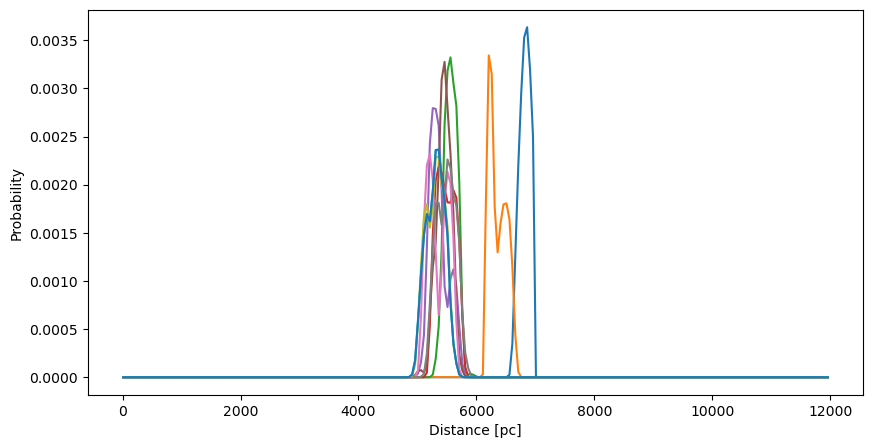

In [112]:
fig,axes = plt.subplots(figsize=(10,5))

for i in range(len(ML)):
    axes.plot(dist_bins,probabilities[i]/norms[i])

axes.set_xlabel("Distance [pc]")
axes.set_ylabel("Probability");
    

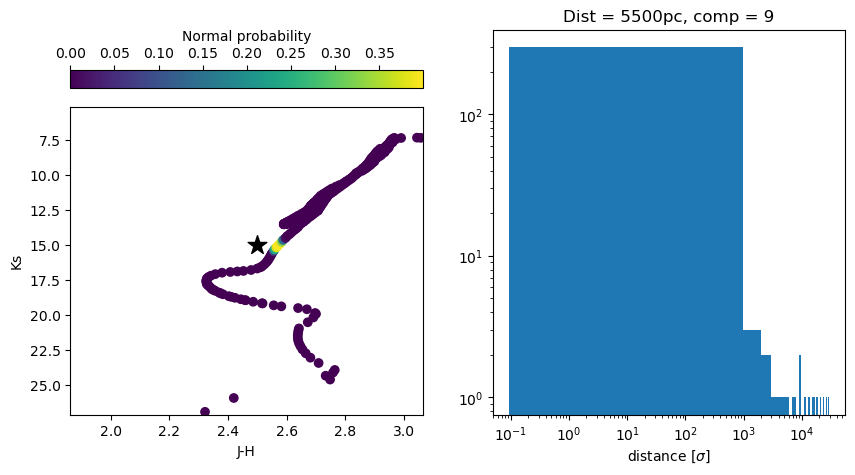

In [92]:
fig,axes = plt.subplots(figsize=(10,5),ncols=2)

DM = 5 * np.log10(0.1*(D + 0.1))
Dist_scale = (1 - np.exp(-D/hscale))

i = 9
app_mag = ML[i][:,mag_index + ML_mag_offset] + absorption_ratio*EJKs*Dist_scale + DM
app_col = ML[i][:,col_index + ML_colour_offset] + extinction_ratio*EJKs*Dist_scale

axes[0].scatter(col,mag,marker="*",s=200,c="k")

cc = axes[0].scatter(app_col,app_mag,c=scipy.stats.norm.pdf(all_dists_std[i]),marker="o",alpha=1,vmin=0,vmax=1/np.sqrt(2*np.pi))
plt.colorbar(cc,ax=axes[0],orientation="horizontal",location="top",label=r"Normal probability")

#cc = axes.scatter((Jmag-Hmag)[dist_std[j,:]<2],Ksmag[dist_std[j,:]<2],c="k",marker="o",alpha=1,vmin=0,vmax=10)

# axes.errorbar(Jmag-Hmag,Ksmag,xerr=np.sqrt(MLi[:,sigma_indices[0]]**2+MLi[:,sigma_indices[1]]**2),
#                    yerr=MLi[:,sigma_indices[2]],alpha=0.3)
# axes.errorbar(Jmag-Hmag,Ksmag,xerr=MLi[:,sigma_indices[0]],
#                    yerr=MLi[:,sigma_indices[2]],alpha=0.3)

plt.title("Dist = {}pc, comp = {}".format(D,i))
axes[0].set_xlabel("J-H")
axes[0].set_ylabel("Ks")
axes[0].set_ylim(12+ absorption_ratio*EJKs*Dist_scale + DM,-10+ absorption_ratio*EJKs*Dist_scale + DM)
axes[0].set_xlim(-0.2+extinction_ratio*EJKs*Dist_scale,1+extinction_ratio*EJKs*Dist_scale);

axes[1].hist(all_dists_std[i],bins=30,log=True)
axes[1].set_xlabel(r"distance [$\sigma$]");
axes[1].set_xscale("log");

## Put all in a function

In [236]:
def get_distance_probabilities(l,b,mag,col,mag_error,col_error,mag_index,col_index,ML,IMF_params,ML_params,dist_bins=np.arange(10,12000,50),_normalise=True):
    def get_gaussian_distance2D_atD(observed_mag,mag_error,observed_colour,colour_error,mag_index,colour_index,absorption_ratio,extinction_ratio,
                                D,EJKs,hscale,MLi,ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,ML_colour_offset,
                                ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset):
        """
        For a given mass-luminosity relation (one component, one isochrone) at a given distance, 
        compute the separation in the CMD space between all the masses and the observed star
        """
        DM = absorption_ratio*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))
        extinction = extinction_ratio*EJKs*(1 - np.exp(-D/hscale))

        sig2_mag = mag_error**2 #+ MLi[:,mag_index+ML_mag_sig_offset]**2
        sig2_col = colour_error**2 #+ MLi[:,colour_index+ML_colour_sig_offset]**2

        distance = (observed_mag-(MLi[:,mag_index+ML_mag_offset] + DM))**2/sig2_mag + (observed_colour-(MLi[:,colour_index+ML_colour_offset] + extinction))**2/sig2_col
        #heavily penalise whenever we are out of bounds
        mask1 = observed_mag>(MLi[:,mag_index+ML_mag_max_offset] + DM)
        mask2 = observed_mag<(MLi[:,mag_index+ML_mag_min_offset] + DM)
        mask3 = observed_colour>(MLi[:,colour_index+ML_colour_max_offset] + extinction)
        mask4 = observed_colour<(MLi[:,colour_index+ML_colour_min_offset] + extinction)

        distance[mask1] = 999
        distance[mask2] = 999
        distance[mask3] = 999
        distance[mask4] = 999

        return distance
    
    def get_gaussian_prob2D_atD(distance):
        prob = scipy.stats.norm.pdf(distance)

        return prob
    def IMF_dNdlogm(mass,Mu = 120,M1 = 0.859770466578045,M2 = 0.08,Ml = 0.001,
                alpha1 = 2.32279457078378,alpha2 = 1.13449983242887,alpha3 = 0.175862190587576):
        
        C1_ = M1**(1-alpha1)*(alpha2-alpha1)/((1-alpha1)*(1-alpha2)) + M1**(alpha2-alpha1)*M2**(1-alpha2)*(alpha3-alpha2)/((1-alpha2)*(1-alpha3))-\
                (Mu**(1-alpha1)/(1-alpha1) + Ml**(1-alpha3)*M2**(alpha3-alpha2)*M1**(alpha2-alpha1)/(1-alpha3))
        C1 = 1/C1_
        C2 = C1*M1**(alpha2-alpha1)
        C3 = C2*M2**(alpha3-alpha2)

        PlogM = np.zeros_like(mass)

        mask1 = (mass>M1) & (mass<=Mu)
        mask2 = (mass>M2) & (mass<=M1)
        mask3 = (mass>Ml) & (mass<=M2)

        PlogM[mask1] = C1*(mass[mask1])**(1-alpha1)
        PlogM[mask2] = C2*(mass[mask2])**(1-alpha2)
        PlogM[mask3] = C3*(mass[mask3])**(1-alpha3)

        return PlogM
    
    def get_basic_params(l,b,mag_index,col_index):
        hscale = getHscale(b)
        Dmean = getDmean(l,b)
        EJKs =  extmap[np.argmin(np.sqrt((extmap[:,0]-l)**2+(extmap[:,1]-b)**2))][-1]
        A0J = EJK2AJ/(1 - np.exp(-Dmean/hscale))
        A0H = EJK2AH/(1 - np.exp(-Dmean/hscale))
        A0Ks = EJK2AKs/(1 - np.exp(-Dmean/hscale))
        A0s = [A0J,A0H,A0Ks]
        E0s = [A0J-A0H,A0J-A0Ks,A0H-A0Ks]

        absorption_ratio = A0s[mag_index]
        extinction_ratio = E0s[col_index]
        return absorption_ratio,extinction_ratio,EJKs,hscale
    

    absorption_ratio,extinction_ratio,EJKs,hscale = get_basic_params(l,b,mag_index,col_index)
    ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,ML_colour_offset,ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset = ML_params

    number_stars = []
    for icomp_,MLi in enumerate(ML):
        number_stars_i = []
        mass_bins = np.clip(MLi[:,0],a_min=IMF_params["Ml"],a_max=IMF_params["Mu"])
        prior = 1/mass_bins*IMF_dNdlogm(mass_bins,Mu=IMF_params["Mu"],Ml=IMF_params["Ml"],M1=IMF_params["M1"],M2=IMF_params["M2"],
                                        alpha1=IMF_params["alpha1"],alpha2=IMF_params["alpha2"],alpha3=IMF_params["alpha3"])
        for D in dist_bins:
            #To-Do: check if it works with only one magnitude
            dist_std = get_gaussian_distance2D_atD(mag,mag_error,col,col_error,mag_index,col_index,absorption_ratio,extinction_ratio,D,EJKs,hscale,MLi,
                                                ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,
                                                ML_colour_offset,ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset,)
            L = scipy.stats.norm.pdf(dist_std)
            post = scipy.integrate.simpson(L*prior,mass_bins)
            number_stars_i.append(post)
        number_stars.append(number_stars_i)
    number_stars = np.array(number_stars)
    if _normalise:
        norms = np.array([scipy.integrate.simpson(N,x=dist_bins) for N in number_stars])
        print(norms)
        return number_stars*(1/norms).reshape(len(number_stars),1)
    else:
        return number_stars

In [148]:
dist_bins = np.arange(10,12000,50)
dist_probs = get_distance_probabilities(0,0,14,3,0.1,0.1,2,0,ML,IMF_params,[ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,ML_colour_offset,ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset],dist_bins,_normalise=True)

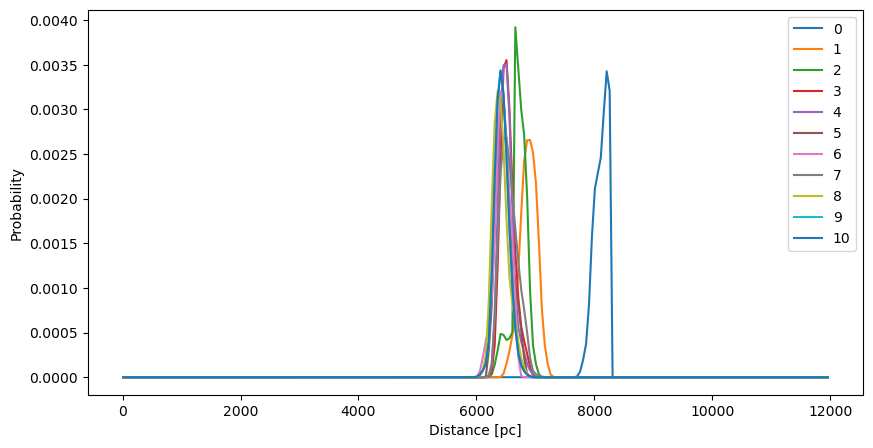

In [149]:
fig,axes = plt.subplots(figsize=(10,5))

for i,d_ in enumerate(dist_probs):
    axes.plot(dist_bins,d_,label="{}".format(i))

axes.set_xlabel("Distance [pc]")
axes.set_ylabel("Probability");
plt.legend();
    

In [166]:
nD = len(dist_bins)-1
x,y,z = get_pos(dist_bins[:nD],l,b,_cyl=False,Dsun=cts["Sun"].getfloat("Dsun"),zsun=cts["Sun"].getfloat("zsun"))
xb =  x * costheta + y * sintheta
yb = -x * sintheta + y * costheta

In [ ]:
def prior_dist(D,x,y,z,icomp,params):
    if icomp<=7:
        return density_dD_los_disc(D,np.sqrt(x**2+y**2),z,params)
    elif icomp == 8:
        return density_dD_los_bulge(D,x,y,z,params)
    elif icomp == 9:
        return density_dD_los_NSD(D,x,y,z,params)
    elif icomp == 10:
        return density_dD_los_NSC(D,x,y,z,params)


def disk_rho(R,z,params):
    """
    Density of the disk components as a function of Galactocentric R and z of the Koshimoto+21 E+E_X model (disk like Portail+17)
    """
    try:
        R0 = float(params["R0"])
    except:
        print("Using default value of R0")
        R0=8160
    try:
        Rdbreak = float(params["Rdbreak"])
    except:
        print("Using default value of Rdbreak")
        Rdbreak = 5300
    try:
        zd = float(params["zd"])
    except:
        print("Using default value of zd (250pc)")
        zd = 250
    try:
        Rd = float(params["Rd"])
    except:
        print("Using default value of Rd (2600pc)")
        Rd = 2600
    try:
        name = params["name"]
    except:
        name = "thin"

    if (name.find("thin")>=0) or (name.find("Thin")>=0):
        return 4.0/(np.exp(2*z/zd)+np.exp(-2*z/zd) + 2)*\
                    np.exp((R0-np.clip(R,a_min=Rdbreak,a_max=np.inf))/Rd)
    elif (name.find("thick")>=0) or (name.find("Thick")>=0):
        return np.exp(-np.abs(z/zd))*\
                    np.exp((R0-np.clip(R,a_min=Rdbreak,a_max=np.inf))/Rd)
    else:
        raise ValueError("Unrecognized disc component name {}.".format(name))
    
def density_dD_los_disc(D,R,z,params,STR2MIN2 = 8.461595e-08):
    return disk_rho(R,z,params) * D**2 * STR2MIN2


def bulge_rho(x,y,z,params):
    """
    Model 5 with X-shape bulge + bar
    """
    try:
        Rc = float(params["Rc"])
    except:
        print("Using default value for Rc")
        Rc = 2631.78535429573
    try:
        zb_c = float(params["zb_c"])
    except:
        print("Using default value for zb_c")
        zb_c=1e6
    try:
        srob = float(params["srob"])
    except:
        print("Using default value for srob")
        srob=500
    try:
        szob = float(params["szob"])
    except:
        print("Using default value for szob")
        szob=200
    try:
        x0_1 = float(params["x0_1"])
    except:
        print("Using default value for x0_1")
        x0_1=930.623146993329
    try:
        y0_1 = float(params["y0_1"])
    except:
        print("Using default value for y0_1")
        y0_1=370.784386649364
    try:
        z0_1 = float(params["z0_1"])
    except:
        print("Using default value for z0_1")
        z0_1=239.547516030578
    try:
        C1 = float(params["C1"])
    except:
        print("Using default value for C1")
        C1=1.20011972384328
    try:
        C2 = float(params["C2"])
    except:
        print("Using default value for C2")
        C2= 4.09326795684828
    try:
        b_zX = float(params["b_zX"])
    except:
        print("Using default value for b_zX")
        b_zX=1.37774815817195
    try:
        b_zY = float(params["b_zY"])
    except:
        print("Using default value for b_zY")
        b_zY=0
    try:
        x0_X = float(params["x0_X"])
    except:
        print("Using default value for x0_X")
        x0_X=278.027059842233
    try:
        y0_X = float(params["y0_X"])
    except:
        print("Using default value for y0_X")
        y0_X=176.318528789193
    try:
        z0_X = float(params["z0_X"])
    except:
        print("Using default value for z0_X")
        z0_X=286.791941602401
    try:
        C1_X = float(params["C1_X"])
    except:
        print("Using default value for C1_X")
        C1_X=1.3087131258784
    try:
        C2_X = float(params["C2_X"])
    except:
        print("Using default value for C2_X")
        C2_X=2.21745322869032
    try:
        fX = float(params["fX"])
    except:
        print("Using default value for fX")
        fX=1.43975636704683
    try:
        Rc_X = float(params["Rc_X"])
    except:
        print("Using default value for Rc_X")
        Rc_X=1301.63829617294


    R = np.sqrt(x**2+y**2)
    xn = np.abs(x/x0_1); yn = np.abs(y/y0_1); zn = np.abs(z/z0_1)
    Rs = (xn**C1 + yn**C1)**(1/C1)
    rs = (Rs**C2 + zn**C2)**(1/C2)
    
    rho = np.exp(-rs)
    rho[R>Rc] = rho[R>Rc]*np.exp(-0.5*(R[R>Rc]-Rc)**2/srob**2)
    rho[np.abs(z)>=zb_c] = rho[np.abs(z)>=zb_c]*np.exp(-0.5*(np.abs(z[np.abs(z)>=zb_c])-zb_c)**2/szob**2)
    
    #add X-shape
    xn = np.abs((x-b_zX*z)/x0_X); yn = np.abs((y-b_zY*z)/y0_X); zn = np.abs(z/z0_X)
    rs = ((xn**C1_X + yn**C1_X)**(C2_X/C1_X) + zn**(C2_X))**(1/C2_X)
    rhoX  =  np.exp(-rs)
    ##add other permutations
    xn = np.abs((x+b_zX*z)/x0_X); 
    rs = ((xn**C1_X + yn**C1_X)**(C2_X/C1_X) + zn**(C2_X))**(1/C2_X)
    rhoX  +=  np.exp(-rs)
    if b_zY>0:
        xn = np.abs((x-b_zX*z)/x0_X); yn = np.abs((y+b_zY*z)/y0_X)
        rs = ((xn**C1_X + yn**C1_X)**(C2_X/C1_X) + zn**(C2_X))**(1/C2_X)
        rhoX  +=  np.exp(-rs)
        xn = np.abs((x+b_zX*z)/x0_X)
        rs = ((xn**C1_X + yn**C1_X)**(C2_X/C1_X) + zn**(C2_X))**(1/C2_X)
        rhoX  +=  np.exp(-rs)
    
    rhoX *= fX
    rhoX[R>=Rc_X] = rhoX[R>=Rc_X]*np.exp(-0.5*(R[R>=Rc_X]-Rc_X)**2/srob**2)
    
    return rho+ rhoX

def density_dD_los_bulge(D,xb,yb,zb,params,STR2MIN2 = 8.461595e-08):                         
    return bulge_rho(xb,yb,zb,params)* D**2 * STR2MIN2


def NSD_rho(xb,yb,zb,params):
    """
    See Eq. (28) of Portail et al. 2017. Values from Sormani et al. 2021
    """
    try:
        x0ND = float(params["x0ND"])
    except:
        print("Using default value for x0ND.")
        x0ND=74
    try:
        y0ND = float(params["y0ND"])
    except:
        print("Using default value for y0ND.")
        y0ND=74
    try:
        z0ND = float(params["z0ND"])
    except:
        print("Using default value for z0ND.")
        z0ND=26
    try:
        C1ND = float(params["C1ND"])
    except:
        print("Using default value for C1ND.")
        C1ND=2
    try:
        RNSDlim = float(params["RNSDlim"])
    except:
        print("Using default value for RNSDlim.")
        RNSDlim=1000
    try:
        zNSDlim = float(params["zNSDlim"])
    except:
        print("Using default value for zNSDlim.")
        zNSDlim=400
    R = np.sqrt(xb**2 + yb**2)
    xn = np.abs(xb/x0ND)
    yn = np.abs(yb/y0ND)
    zn = np.abs(zb/z0ND)
    rs = (xn**C1ND + yn**C1ND)**(1/C1ND) + zn
    rho = np.zeros_like(R)
    rho[(R<RNSDlim)&(np.abs(zb)<zNSDlim)] = np.exp(-rs[(R<RNSDlim)&(np.abs(zb)<zNSDlim)])
    return rho

def NSC_rho(R,z,params):
    """
    From Chatzopoulos et al. 2015
    """
    try:
        qNSC = float(params["qNSC"])
    except:
        print("Using default value for qNSC.")
        qNSC=0.73
    try:
        aNSC_lim = float(params["aNSC_lim"])
    except:
        print("Using default value for aNSC_lim.")
        aNSC_lim = 200
    try:
        a0NSC = float(params["a0NSC"])
    except:
        print("Using default value for a0NSC.")
        a0NSC=5.9
    try:
        gammaNSC = float(params["gammaNSC"])
    except:
        print("Using default value for gammaNSC.")
        gammaNSC=0.71


    zq = z/qNSC
    aNSC = np.sqrt(R**2 + zq**2)
    rho = np.zeros_like(R)
    rho[aNSC < aNSC_lim] = a0NSC/((aNSC[aNSC < aNSC_lim])**gammaNSC * (aNSC[aNSC < aNSC_lim]+a0NSC)**(4-gammaNSC))
    return rho

def density_dD_los_NSD(D,xb,yb,zb,params,STR2MIN2 = 8.461595e-08):
    """
    rho0NSD=0.25*7e8
    """       
    return NSD_rho(xb,yb,zb,params)* D**2 * STR2MIN2


def density_dD_los_NSC(D,xb,yb,zb,params,STR2MIN2 = 8.461595e-08):
    """
    rho0NSC=(3-0.71)*0.25*6.1e7/np.pi/0.73
    """       
    R = np.sqrt(xb**2+yb**2)
    return NSC_rho(R,zb,params)* D**2 * STR2MIN2

In [195]:
PD = []

for icomp,name in enumerate(components_names):
    if icomp<=7:
        PD.append(prior_dist(dist_bins[:nD],x,y,z,icomp,dict(cts[name])))
    else:
        PD.append(prior_dist(dist_bins[:nD],xb,yb,z,icomp,dict(cts[name])))

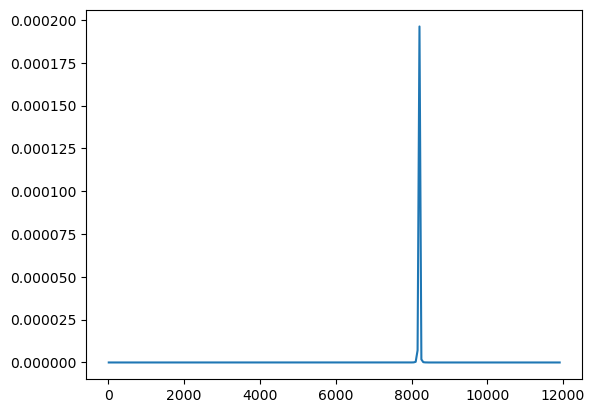

In [ ]:
i = 10
plt.plot(dist_bins[:-1],PD[i])

In [238]:
def compute_full_posterior(l,b,parallax,mag,col,parallax_error,mag_error,col_error,mag_index,col_index,ML,Priordist,IMF_params,ML_params,n0MS,dist_bins=np.arange(10,12000,50)):
    """
    Get posterior distribution function of the Distance given all observables:

    - plx: observed parallax in mas
    - plx_error: error in observed parallax in mas
    """

    #compute likelihood
        #likelihood of the CMD
    PCMD_d_normalised = get_distance_probabilities(l,b,mag,col,mag_error,col_error,mag_index,col_index,ML,IMF_params,ML_params,dist_bins,_normalise=True)
    print(np.min(PCMD_d_normalised,axis=1))
    if parallax is not None:
        #use distance in kpc because parallax is in mas
        L_plx = scipy.stats.norm.pdf(1000/dist_bins,loc=parallax,scale=parallax_error)
        normPlx = scipy.integrate.simpson(y=L_plx,x=dist_bins)
        Pplx_d_norm = L_plx/normPlx
        print(np.min(Pplx_d_norm))
    else:
        Pplx_d_norm = 1
    Post_dist = [n0MS[icomp]*Pplx_d_norm*P*Priordist[icomp] for icomp,P in enumerate(PCMD_d_normalised)]

    return Post_dist

In [253]:
plx = None#1/2
plx_err = None#plx/5
mag = 14
col = 4
mag_err = 0.5
col_err = 0.5

l,b = 0,0

dist_bins = np.arange(10,12000,50)

nD = len(dist_bins)-1
x,y,z = get_pos(dist_bins[:nD],l,b,_cyl=False,Dsun=cts["Sun"].getfloat("Dsun"),zsun=cts["Sun"].getfloat("zsun"))
xb =  x * costheta + y * sintheta
yb = -x * sintheta + y * costheta

PD = []

for icomp,name in enumerate(components_names):
    if icomp<=7:
        PD.append(prior_dist(dist_bins[:nD],x,y,z,icomp,dict(cts[name])))
    else:
        PD.append(prior_dist(dist_bins[:nD],xb,yb,z,icomp,dict(cts[name])))
        
dist_probs = compute_full_posterior(l,b,plx,mag,col,plx_err,mag_err,col_err,2,0,ML,PD,IMF_params,[ML_mag_offset,ML_mag_sig_offset,ML_mag_max_offset,ML_mag_min_offset,ML_colour_offset,ML_colour_sig_offset,ML_colour_max_offset,ML_colour_min_offset],n0MS,dist_bins[:nD])

[0.00230029 0.16002223 0.14328557 0.08899277 0.05067939 0.04716969
 0.03865473 0.09209403 0.10199838 0.11326231 0.11326231]
[-3.00860293e-098  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
 -4.94065646e-323  0.00000000e+000  0.00000000e+000]


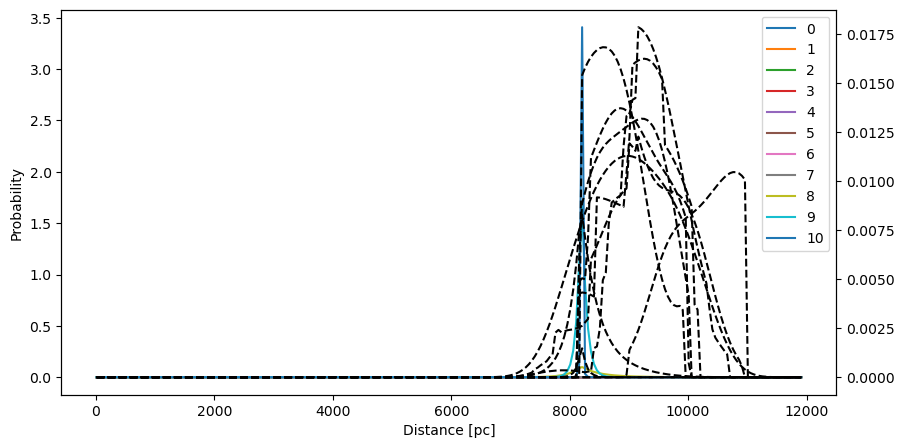

In [254]:
fig,axes = plt.subplots(figsize=(10,5))

for i,d_ in enumerate(dist_probs):
    axes.plot(dist_bins[:nD],d_,label="{}".format(i))

ax = axes.twinx()
for i,d_ in enumerate(dist_probs):
    ax.plot(dist_bins[:nD],d_/n0MS[i],color="k",ls="--")

axes.set_xlabel("Distance [pc]")
axes.set_ylabel("Probability");
axes.legend();


In [255]:
best_dists = []
for i,prob in enumerate(dist_probs):
    best_dists.append(dist_bins[np.argmax(prob)])

In [256]:
best_dists

[10760, 9160, 9160, 9260, 8860, 9210, 8560, 8960, 8210, 8210, 8210]

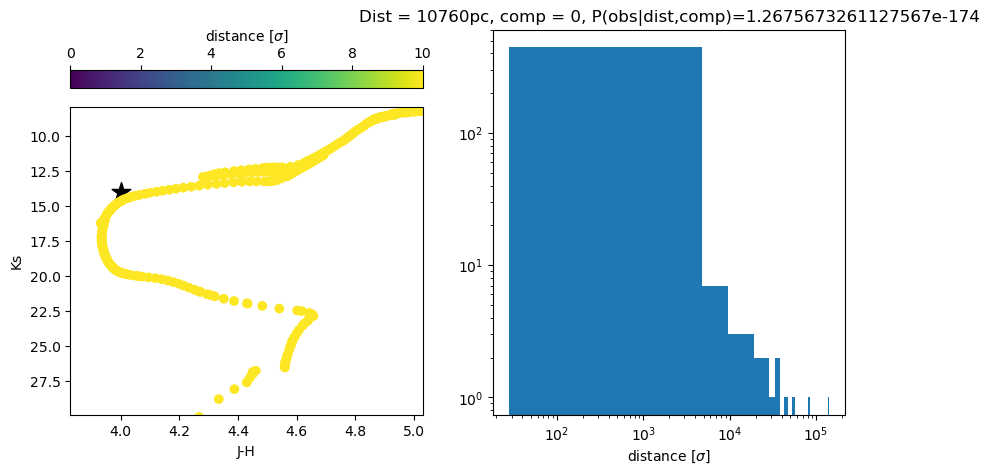

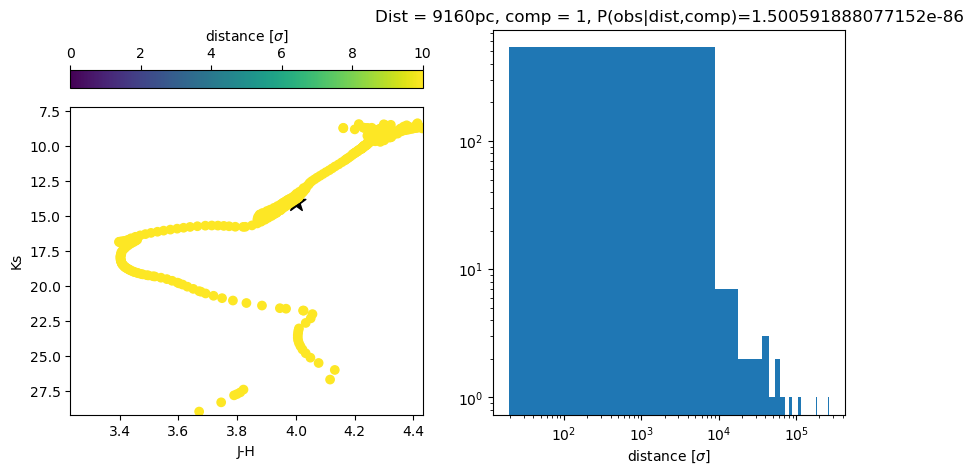

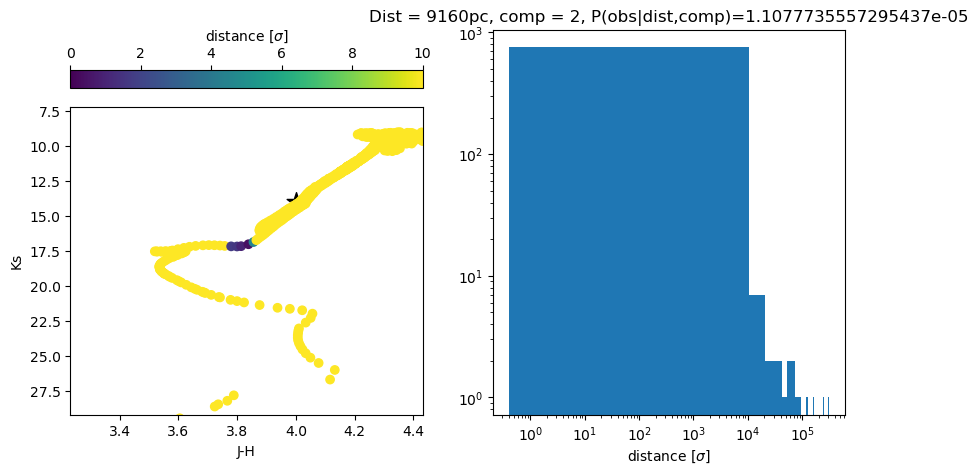

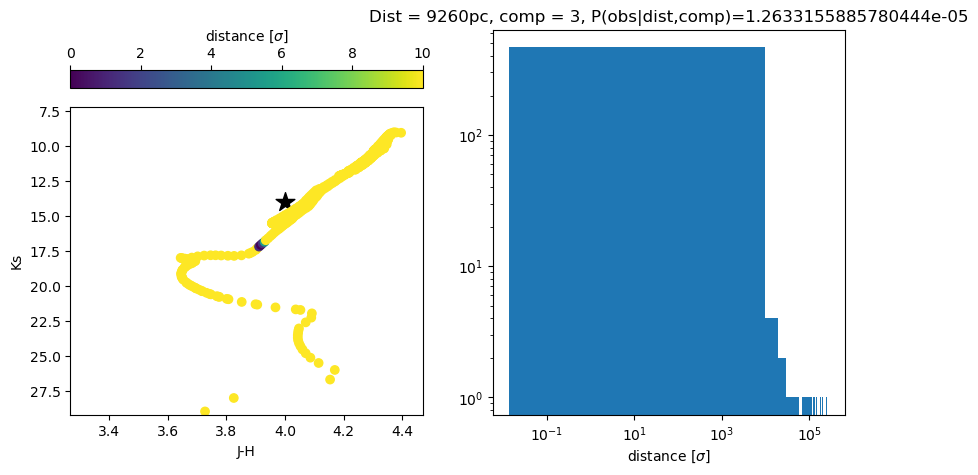

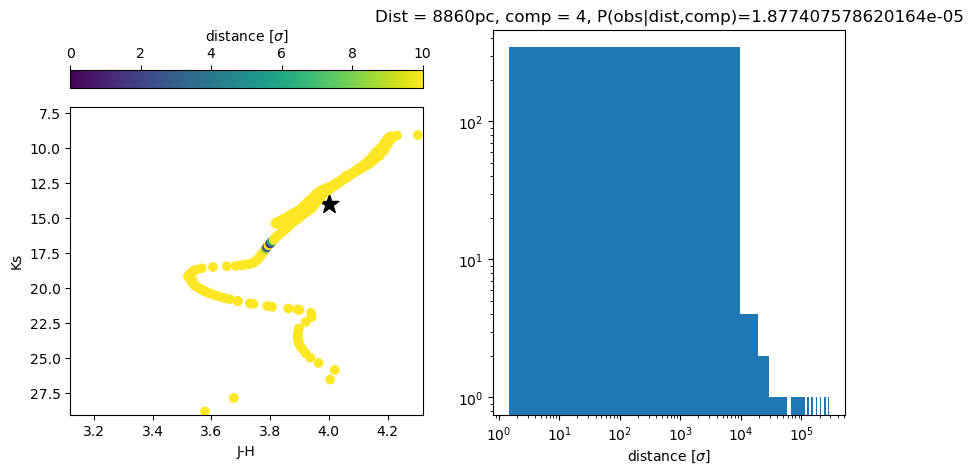

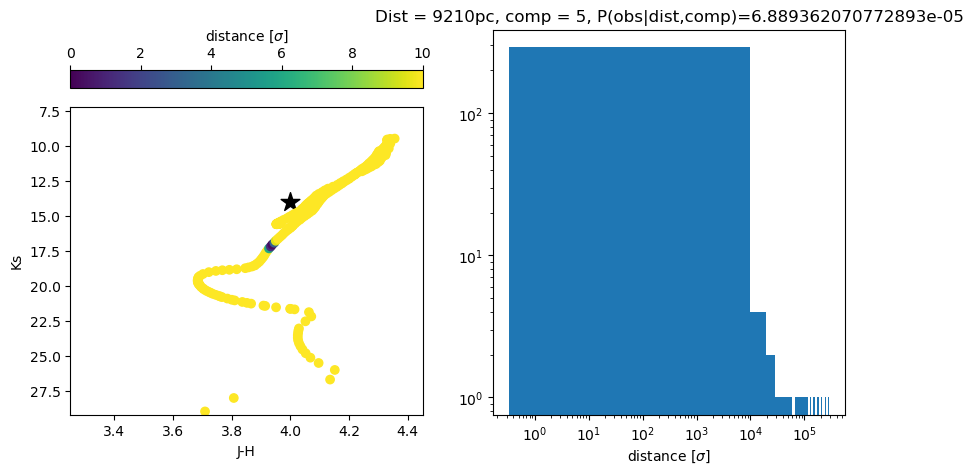

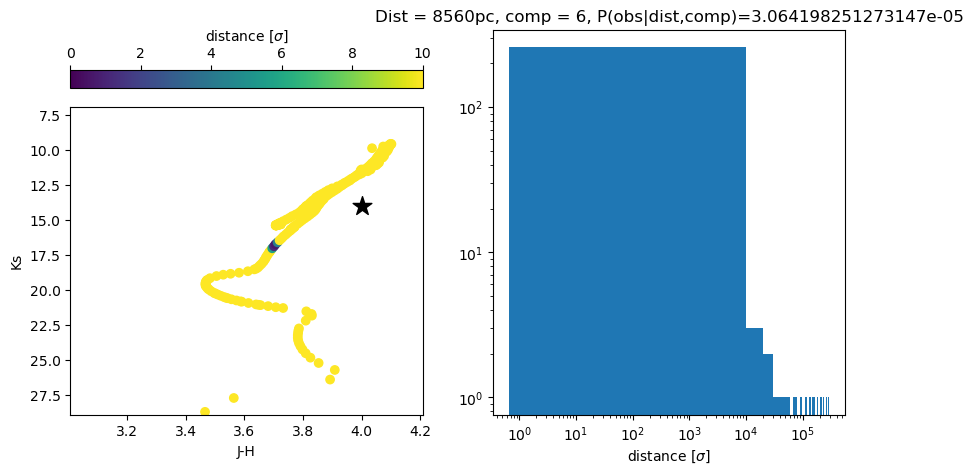

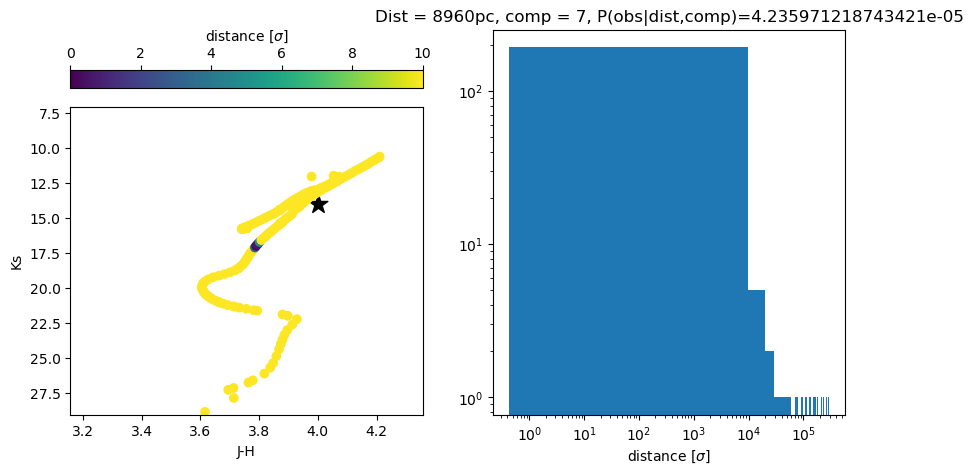

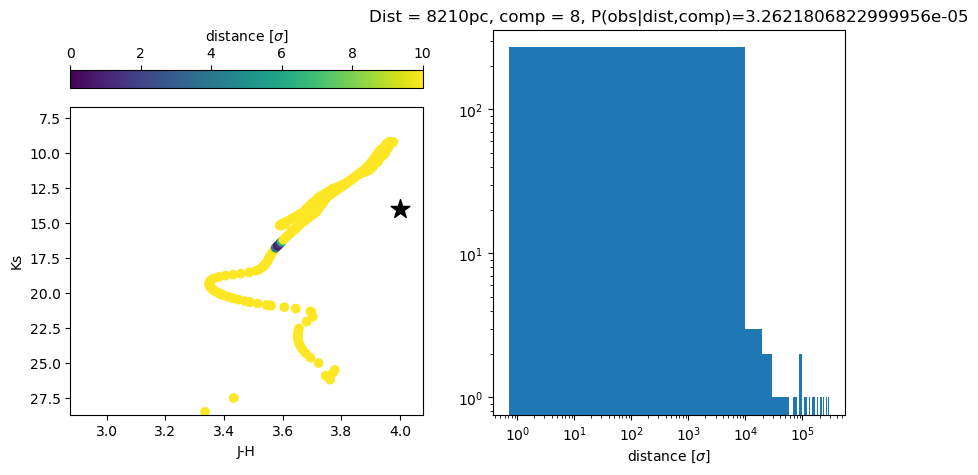

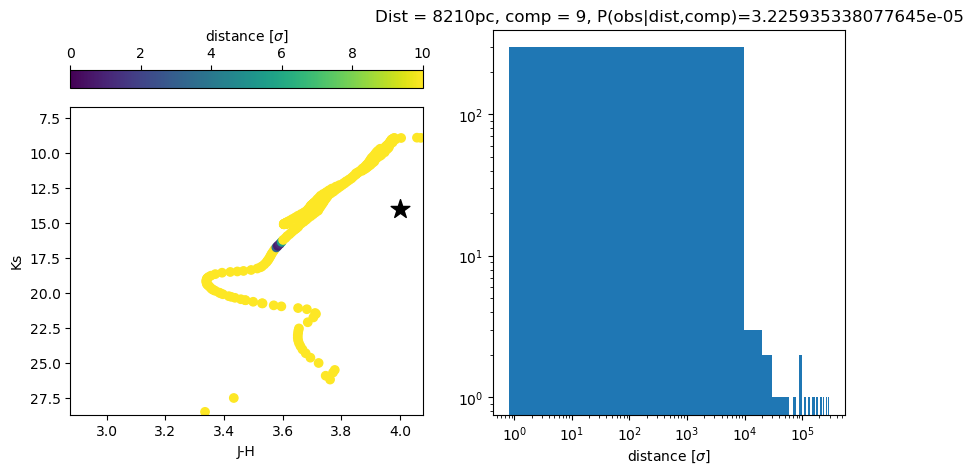

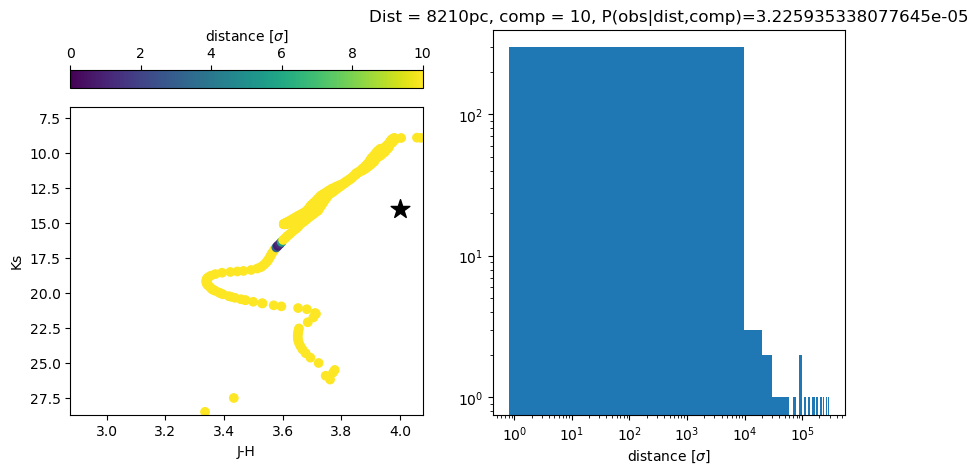

In [257]:
for i in range(len(ML)):
    D = best_dists[i]
    fig,axes = plt.subplots(figsize=(10,5),ncols=2)

    DM = 5 * np.log10(0.1*(D + 0.1))
    Dist_scale = (1 - np.exp(-D/hscale))

    app_mag = ML[i][:,mag_index + ML_mag_offset] + absorption_ratio*EJKs*Dist_scale + DM
    app_col = ML[i][:,col_index + ML_colour_offset] + extinction_ratio*EJKs*Dist_scale

    axes[0].scatter(col,mag,marker="*",s=200,c="k")

    cc = axes[0].scatter(app_col,app_mag,c=all_dists_std[i],marker="o",alpha=1,vmin=0,vmax=10)
    plt.colorbar(cc,ax=axes[0],orientation="horizontal",location="top",label=r"distance [$\sigma$]")

    plt.title("Dist = {}pc, comp = {}, P(obs|dist,comp)={}".format(D,i,posteriors[i]))
    axes[0].set_xlabel("J-H")
    axes[0].set_ylabel("Ks")
    axes[0].set_ylim(12+ absorption_ratio*EJKs*Dist_scale + DM,-10+ absorption_ratio*EJKs*Dist_scale + DM)
    axes[0].set_xlim(-0.2+extinction_ratio*EJKs*Dist_scale,1+extinction_ratio*EJKs*Dist_scale);

    axes[1].hist(all_dists_std[i],bins=30,log=True)
    axes[1].set_xlabel(r"distance [$\sigma$]");
    axes[1].set_xscale("log");